## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests
from scipy import stats

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [ ]:
print(alldat.shape)

(39,)


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

0.01
0.01


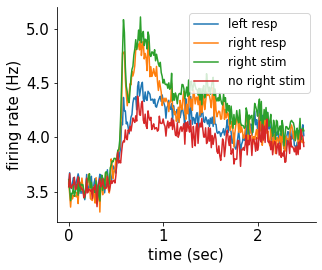

In [ ]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size']
print(dat['bin_size']) # binning at 10 ms
NT = dat['spks'].shape[-1]
print(dt)

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
#plt.plot(dt*np.arange(NT), 1/dt * dat['spks'][:, 0])
print(dat['spks'][:,0])

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region



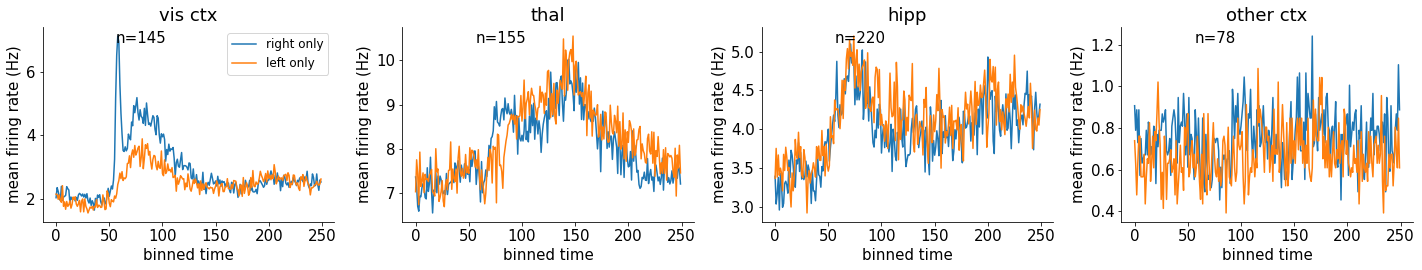

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1))) 
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#prints out the average firing rate of each neuron given the direction of the stimulus

# fig = plt.figure(figsize=(18.0, 180.0))
# for i in range(1, 120):
#   axes_x = fig.add_subplot(40, 3, i)
#   trial_mean = np.mean(dat['spks'][barea==0][i,:,:], axis=0)
#   plt.plot(1/dt *  np.mean(dat['spks'][barea==0][i,np.logical_and(vis_left==0, vis_right>0)], axis=(0)))
#   plt.plot(1/dt *  np.mean(dat['spks'][barea==0][i,np.logical_and(vis_left>0 , vis_right==0)], axis=(0)))
#   plt.plot(1/dt * trial_mean)
#   axes_x.set_ylabel('mean firing rate (Hz)')
#   axes_x.legend(['right only', 'left only', 'average'], fontsize=12)
#   axes_x.set_ylim(-1, 8)  
  




In [ ]:
#initialize
dat = alldat[11]
print(dat['spks'].shape)

(698, 340, 250)


In [ ]:
#run t-test on data
def t_test_each_point(data):
  '''
  used an alpha of .05

  returns an array of ones and zeroes, the ones represent that they are significantly different,
  the zeros show they are not
  '''
  #setting up variables
  sigma_R = np.std(data[:,0])
  sigma_L = np.std(data[:,1])
  N_R = len(data[:,0])
  N_L = len(data[:,1])
  degree_freedom = (N_R + N_L - 2)
  pooled_sigma = (sigma_R *(N_R - 1) + sigma_L *(N_L - 1))/ degree_freedom
  sigma_difference = np.sqrt((pooled_sigma**2/N_R)+(pooled_sigma**2/N_L))
  
  #create array to hold t scores
  t_scores = np.zeros((N_R,))
  
  #determine t score for each neuron
  for i in range(0, N_R -1):
    difference = data[i, 0] - data[i, 1]
    t_scores[i] = difference / sigma_difference
  
  #update number for degrees of freedom
  critical_t_value = 1.97
  
  #comparing t scores to the critical t value and determine 
  #if the two are statistically different
  significantly_different = np.zeros((N_R,))
  for i in range(0, N_R -1):
    if (np.abs(t_scores[i]) > critical_t_value):
      significantly_different[i] += 1
  
  return significantly_different



In [ ]:
#takes z score of data
def normalize_data(data):
  
  normalized_data = (data - np.mean(data))/np.std(data)
  
  return normalized_data


#split 39 sessions into 20 and 19
training_data = alldat[:20]
test_data = alldat[20:]

# alldat[session_number]['spks'].shape[0]
def classify_neurons(dat):
  '''
  input: dictionary of a single session
  takes a session of data and returns an array of which direction each neuron is selective for
  '''
  #average for each neuron across trials taking into acount where the stimulus came from
  #column 1 is right, column 2 is left
  neuron_number = dat['spks'][barea == 0].shape[0]

  if neuron_number == 0:
    return None

  mean_firing_rate = np.zeros((neuron_number, 2))
  for i in range(1, neuron_number):
    mean_firing_rate[(i-1), 0] = 1/dt * np.mean(dat['spks'][barea==0][i,np.logical_and(vis_left==0, vis_right>0)])
    mean_firing_rate[(i-1), 1] = 1/dt * np.mean(dat['spks'][barea==0][i,np.logical_and(vis_left>0, vis_right==0)])

  #make data bound from 0 to 1
  normalized_mean_firing_rate = normalize_data(mean_firing_rate)

  #run t test on data
  significantly_different = t_test_each_point(normalized_mean_firing_rate)

  #classify each neuron on which direction is favored only if the 2 values are statistically different
  direction_favored = np.zeros((neuron_number,))
  for i in range(1, neuron_number-1):
    if significantly_different[i-1]:
      if mean_firing_rate[i-1, 0] > mean_firing_rate[i-1, 1]:
        direction_favored[i-1] = -1
      else:
        direction_favored[i-1] = 1
    else:
      direction_favored[i-1] = 0
  
  return direction_favored


pRight_real = np.zeros((20,))
rt_real = np.zeros((20,))
all_direction_favored = []
for session in range(len(training_data)):
  dat = training_data[session]
  nareas = 4 # only the top 4 regions are in this particular mouse
  NN = len(dat['brain_area']) # number of neurons
  barea = nareas * np.ones(NN, ) # last one is "other"
  for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
  vis_right = dat['contrast_right']
  vis_left = dat['contrast_left']
  #for real reaction times
  response_time = dat['response_time']
  # print(rt_real)
  rt_real[session] = np.abs(np.diff(response_time, 1, 0)).mean()
  # print(rt_real_right)
  #for the real probabilities
  real_choice = dat['response']
  right_choice = np.sum(real_choice[real_choice == 1])
  pRight_real[session] = right_choice / len(real_choice)
  all_direction_favored.append(classify_neurons(dat))



#print(mean_firing_rate)
#finding average spike rate depending on direction favored
# right_neurons_average = 1/dt * np.mean(dat['spks'][barea==0][direction_favored == -1, :,:])
# left_neurons_average = 1/dt * np.mean(dat['spks'][barea==0][direction_favored == 1, :,:])
# right_neurons_std = 1/dt * np.std(dat['spks'][barea==0][direction_favored == -1, :,:])
# left_neurons_std = 1/dt * np.std(dat['spks'][barea==0][direction_favored == 1, :,:])
# print(right_neurons_average, left_neurons_average, right_neurons_std, left_neurons_std)

In [ ]:
def neurons_stats_over_sessions(data, direction_favored):
  if direction_favored is None:
    return 0
  right_neurons_average = 1/dt * np.mean(data['spks'][barea==0][direction_favored == -1, :,:])
  left_neurons_average = 1/dt * np.mean(data['spks'][barea==0][direction_favored == 1, :,:])
  right_neurons_std = 1/dt * np.std(data['spks'][barea==0][direction_favored == -1, :,:])
  left_neurons_std = 1/dt * np.std(data['spks'][barea==0][direction_favored == 1, :,:])

  return right_neurons_average, left_neurons_average, right_neurons_std, left_neurons_std

In [ ]:
neurons_stats = np.zeros((20, 4))
for session in range(len(training_data)):
  dat = training_data[session]
  nareas = 4 # only the top 4 regions are in this particular mouse
  NN = len(dat['brain_area']) # number of neurons
  barea = nareas * np.ones(NN, ) # last one is "other"
  for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
  vis_right = dat['contrast_right']
  vis_left = dat['contrast_left']
  neurons_stats[session] = neurons_stats_over_sessions(dat, all_direction_favored[session])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Each index of neurons_stats array represent a session which contains an array 
# with four values in it (right_neurons_average, left_neurons_average, right_neurons_std, left_neurons_std)
neurons_stats

array([[ 4.78537658,  5.57350192, 25.44216145, 24.16721484],
       [ 2.58227888,  2.91635881, 16.54835854, 18.27464244],
       [ 4.03115105,  4.20271132, 20.80949855, 20.50461633],
       [ 2.9729585 ,  3.18964748, 17.34281691, 19.29410691],
       [ 1.40183727,  1.12627058, 12.0215553 , 10.82191121],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.77714286,  8.03093333, 13.66524446, 27.7807627 ],
       [ 3.54344086,  0.80215054, 18.95844196,  8.98833946],
       [ 2.60667488,  1.64758999, 16.53135204, 12.84291717],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.45327731,  3.53941176, 15.70325045, 18.60007421],
       [ 0.308     ,  2.68933333,  5.54122153, 16.31395918],
       [        nan,  2.51134328,         nan, 15.6983892 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [ ]:
#fix None values
neurons_stats[13, 0] = 0
neurons_stats[13, 2] = 0

#taking the difference in mean/std (right - left)
difference_mean = np.mean(neurons_stats[:, 0]) - np.mean(neurons_stats[:, 1])
difference_std = np.sqrt(np.mean(neurons_stats[:, 2])**2 + np.mean(neurons_stats[:, 3])**2)

ntrials = 5000
maxdur = 800
time_step = 10

time_axis = np.arange(0, maxdur, time_step)
#list to hold the data we will be using for our simulation
simulation_data = []
for i in range(neurons_stats.shape[0]):
  #eliminate the zeros
  if (neurons_stats[i, 0] == 0):
    continue
  simulation_data.append(neurons_stats[i, 0] - neurons_stats[i,1])

sample = np.random.choice(simulation_data, size = ntrials, replace = True)

#paramaters
k = 0.3
B = 100
sigma = difference_std

#initialize variables
dv = np.zeros((ntrials, len(time_axis))) 
choice = np.zeros((ntrials, 1 ))
RT = np.zeros((ntrials))
finalV = np.zeros((ntrials, 1))
hit_bound = np.zeros((ntrials, 1))


for n in range(ntrials):
  mu = k * sample[n]
  dv[n, 1:] = np.cumsum(np.random.normal(loc = mu, scale = sigma, size = len(time_axis) - 1))
  
  count = 100000000000
  for i in range(dv.shape[1]):
    if np.abs(dv[n, i]) >= B:
      if np.abs(dv[n, i]) <= count:
        cRT = i
        count = np.abs(dv[n,i])
    else:
      cRT = None
  
  if cRT is None:
    RT[n] = maxdur
    finalV[n] = dv[n, 79]
    hit_bound[n] = 0
  else:
    RT[n] = cRT
    finalV[n] = B * np.sign(dv[n, cRT])
    hit_bound[n] = 1
  choice[n] = np.sign(finalV[n])







[0.45687646 0.4775     0.4837963  0.49514563 0.55940594 0.13908873
 0.69419643 0.59545455 0.41361257 0.31937173 0.54146341 0.35135135]
[0.3317757  0.32669323 0.25       0.20481928 0.20866142 0.396
 0.39247312 0.42729306 0.39705882 0.45666667 0.30364372 0.2212766 ]


Text(0.5, 1.0, 'Simulated Drift-Diffusion versus Real Data')

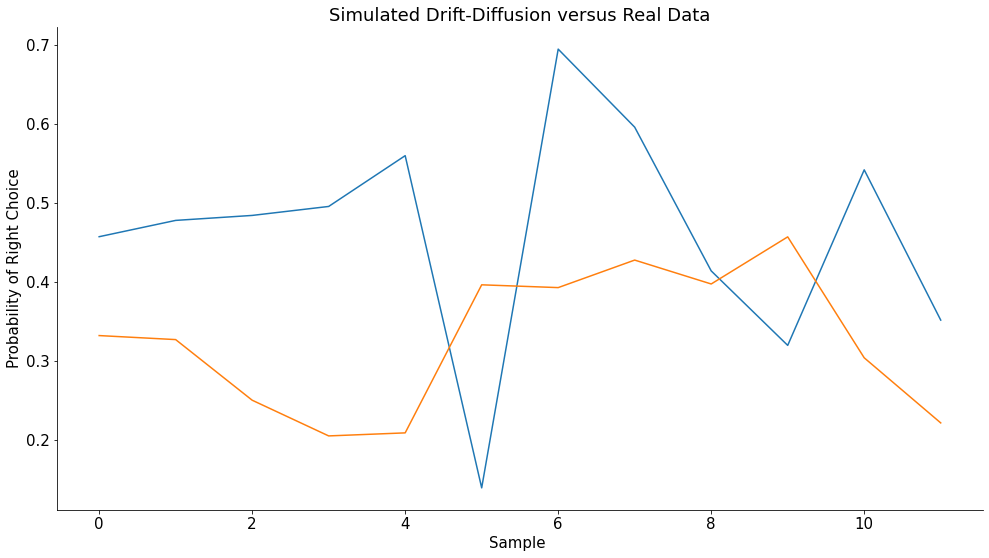

In [ ]:


#probability right estimated
response_time_estimated = np.zeros(len(simulation_data))
pRight_estimated = np.zeros((12,))
for sim1 in range(len(simulation_data)):
  I = sample == simulation_data[sim1]
  rt_sample = 0
  count = 0
  for sim2 in range(len(I)):
    if choice[sim2] == 1 and I[sim2]:
      count += 1
    # rt_sample += RT[sim2]
  # rt_sample /= len(I) #Calculating average response time for sample
  rt_sample = np.mean(RT[I])
  response_time_estimated[sim1] = rt_sample
  pRight_estimated[sim1] = count / np.sum(I)

response_time_estimated /= 1000

#probability left estimated
pLeft_estimated = 1 - pRight_estimated


#probability right real data
print(pRight_estimated)

pRight_real_updated = np.zeros((12,))
count = 0
for i in range(len(pRight_real)):
  if (i in [5,6,10,13,14,15,16,17]):
    continue
  else:
    pRight_real_updated[count] = pRight_real[i]
    count +=1
#probability left real data
pLeft_real = 1 - pRight_real_updated
print(pRight_real_updated)




fig = plt.figure(figsize=(14.0, 8.0))
axes1 = fig.add_subplot(1,1,1)
axes1.set_ylabel('Probability of Right Choice')
axes1.plot(pRight_estimated, label = 'estimated')
axes1.plot(pRight_real_updated, label = 'real value')


,
plt.xlabel('Sample ')
plt.ylabel('Probability of Right Choice')
plt.title('Simulated Drift_Diffusion versus Real Data')

plt.xlabel('Sample ')
plt.ylabel('Probability of Right Choice')
plt.title('Simulated Drift-Diffusion versus Real Data')



In [ ]:
(rt_real).mean()
# (RT[0:20]/1000)

0.6457996272906048

Text(0.5, 1.0, 'Simulated Response Time vs Real Response Time')

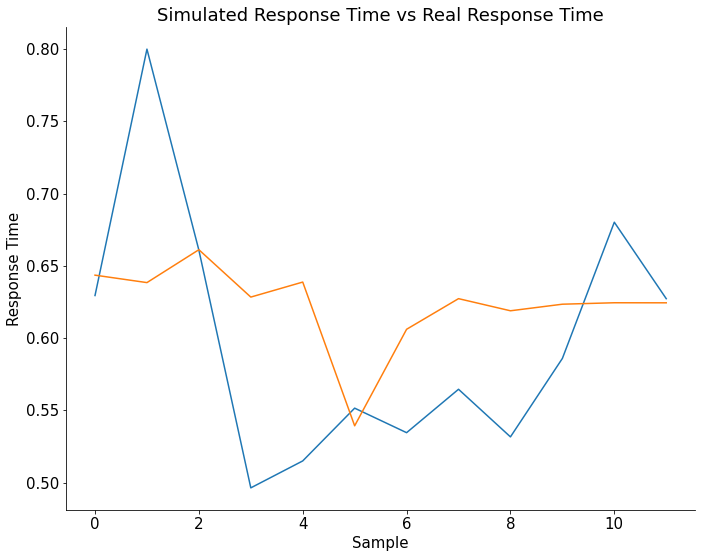

In [ ]:
#reaction time real
fig = plt.figure(figsize=(10.0, 8.0))
axes1 = fig.add_subplot(1,1,1)
axes1.set_ylabel('Response Time')
axes1.plot(rt_real[8:20], label = 'real response time')
axes1.plot(response_time_estimated, label = 'estimated response time')

plt.xlabel('Sample')
plt.ylabel('Response Time')
plt.title('Simulated Response Time vs Real Response Time')

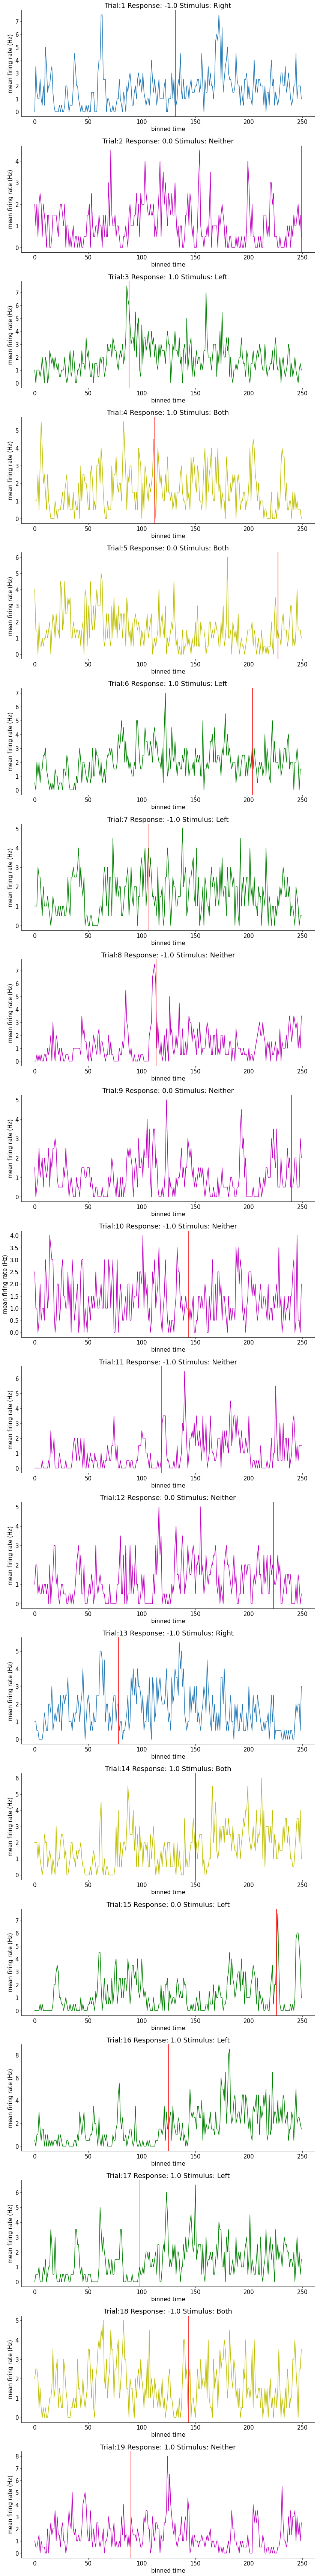

In [ ]:
#plots the average of all neurons across a single trial and show response time
#for i in range(1, 10):
# fig = plt.figure(figsize=(12, 120.0))
# for i in range(1, 20):  
#   axes_x = fig.add_subplot(20, 1, i)
#   plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)))
#   plt.axvline(x = (1/dt * dat['response_time'][i]), color = 'red')
#   axes_x.set_ylabel('mean firing rate (Hz)')
#plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0),:])
# plt.plot(1/dt *  dat['spks'][barea==j][:,1,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0)))
# plt.plot(1/dt *  dat['spks'][barea==j][:,1,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0)))
# plt.plot(1/dt *  dat['spks'][barea==j][:,1,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0)))
right_only = np.logical_and(vis_left==0, vis_right>0)
left_only = np.logical_and(vis_left>0 , vis_right==0)
neither = np.logical_and(vis_left==0 , vis_right==0)
both = np.logical_and(vis_left>0 , vis_right>0)

# fig = plt.figure(figsize=(12, 120.0))
# count = 0
# for i, element in enumerate(right_only):  
#   if element == True:
#     count += 1
#     axes_x = fig.add_subplot(20, 1, count)
#     plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)))
#     plt.axvline(x = (1/dt * dat['response_time'][i]), color = 'red')
#     axes_x.set_ylabel('mean firing rate (Hz)')
#   else:
#     continue


fig = plt.figure(figsize=(12.0, 100.0))
for i in range(1, 20): # for 20 cases only for analysis
  if right_only[i]:
    axes_x = fig.add_subplot(20, 1, i)
    plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)))
    plt.axvline(x = (1/dt * dat['response_time'][i]), color='red')
    axes_x.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = 'Trial:' + str(i) + " Response: " + str(dat['response'][i]) + ' Stimulus: Right')
  elif left_only[i]:
    axes_x = fig.add_subplot(20, 1, i)
    plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)), color = 'green')
    plt.axvline(x = (1/dt * dat['response_time'][i]), color='red')
    axes_x.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = 'Trial:' + str(i) + " Response: " + str(dat['response'][i])+ ' Stimulus: Left')
  elif neither[i]:
    axes_x = fig.add_subplot(20, 1, i)
    plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)), color = 'm')
    plt.axvline(x = (1/dt * dat['response_time'][i]), color='red')
    axes_x.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = 'Trial:' + str(i)+ " Response: " + str(dat['response'][i])+ ' Stimulus: Neither' )
  else:
    axes_x = fig.add_subplot(20, 1, i)
    plt.plot(1/dt *  dat['spks'][barea==0][:,i,:].mean(axis=(0)), color = 'y')
    plt.axvline(x = (1/dt * dat['response_time'][i]), color='red')
    axes_x.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = 'Trial:' + str(i)+ " Response: " + str(dat['response'][i])+ ' Stimulus: Both' )

# right - nogo - left (-1, 0, 1)


  

In [ ]:
# finding average firing rate for each stimulus
firing_rate_at_response = []

mean_firing_rate =  

SyntaxError: ignored

In [ ]:
##@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')